In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [2]:
# Оценка качества 
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

### Загрузка данных

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
test_df = pd.read_csv('test.csv')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [6]:
# Проверим соответсвие признаков на тесте и на обучении - 1 целевой признак
train_df.shape[1] - 1 == test_df.shape[1]

True

### Целевая переменная

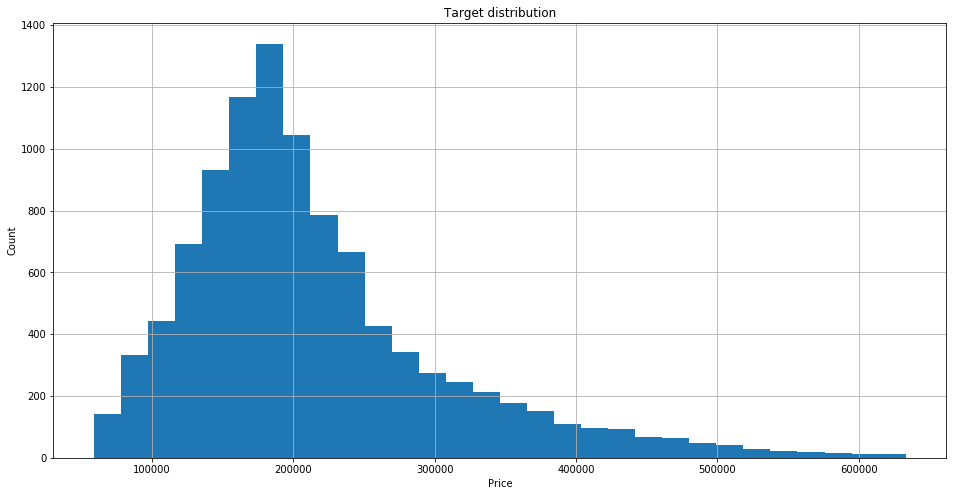

In [7]:
# Посмотрим, что представляет целевая переменная (все ли адекватно)
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

### Количественные переменные

In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Переменные *LifeSquare* и *Healthcare_1* заполнены не полностью, *HouseYear* имеет аномальный максимум, *Social_3* и *Healthcare_1* возможно имеют выбросы

### Номинативные переменные

In [9]:
object_list = train_df.select_dtypes(include='object').columns.tolist()
for i in object_list:
    print(f'{i} value counts')
    print(train_df[i].value_counts())
    print('-'*50)

Id value counts
8409     1
7332     1
3973     1
2384     1
10200    1
        ..
5528     1
13739    1
15558    1
1074     1
7550     1
Name: Id, Length: 10000, dtype: int64
--------------------------------------------------
DistrictId value counts
27     851
1      652
23     565
6      511
9      294
      ... 
199      1
207      1
196      1
117      1
174      1
Name: DistrictId, Length: 205, dtype: int64
--------------------------------------------------
Ecology_2 value counts
B    9903
A      97
Name: Ecology_2, dtype: int64
--------------------------------------------------
Ecology_3 value counts
B    9725
A     275
Name: Ecology_3, dtype: int64
--------------------------------------------------
Shops_2 value counts
B    9175
A     825
Name: Shops_2, dtype: int64
--------------------------------------------------


* Похоже на то, что: B - небольшие магазины, A - торговые центры, крупные магазины

### Обработка выбросов

#### Обработка столбца Rooms

In [10]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [11]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [12]:
train_df.loc[train_df['Rooms'] <= 0, 'Rooms'] = train_df['Rooms'].quantile(.05)
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].quantile(.95)

In [13]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2239
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Обработка столбца KitchenSquare

In [14]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### Обработка столбцов HouseFloor, Floor

In [15]:
# Самый высокий дом в Москве имеет 95 этажей (Башня Федерация, Башня «Восток»)
train_df.loc[(train_df['HouseFloor'] <= 0), 'HouseFloor'] = 1
train_df.loc[(train_df['HouseFloor'] > 95), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

# Если этаж больше этажности дома, то заменяем случайным значением меньшим этажности
floor_great_house = train_df.loc[(train_df['Floor'] > train_df['HouseFloor'])].index
train_df.loc[floor_great_house, 'Floor'] = train_df.loc[floor_great_house, 'HouseFloor'].apply(lambda x: random.randint(1,x))

In [16]:
# Проверяем, что этаж меньше этажности
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### Обработка столбца HouseYear

In [17]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

In [18]:
train_df['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7246    2020
2350    2020
8296    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

### Обработка пропусков

#### Обработка столбца LifeSquare

In [19]:
# В настоящее время в Москве максимальная площадь квартиры составляет 830 кв.м. 
train_df.loc[(train_df['Square'] < 18), 'Square'] = 18
train_df.loc[(train_df['Square'] > 830), 'Square'] = train_df['Square'].median()

In [20]:
# Откорректируем жилую площадь 
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna()*1
train_df['LifeSquare_nan'] 
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna())\
             & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3
train_df.loc[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(0.125)), 'LifeSquare'] \
             = train_df['LifeSquare'].quantile(0.125)
train_df.loc[(train_df['LifeSquare'] > 810), 'LifeSquare'] = train_df['LifeSquare'].median()

incorrect_lifesquare = train_df.loc[(train_df['LifeSquare'] > train_df['Square']), ['Square', 'LifeSquare']].index
train_df.loc[incorrect_lifesquare, ['Square', 'LifeSquare']] = train_df.loc[incorrect_lifesquare, ['LifeSquare', 'Square']].values
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), ['LifeSquare', 'Square']]

,LifeSquare,Square


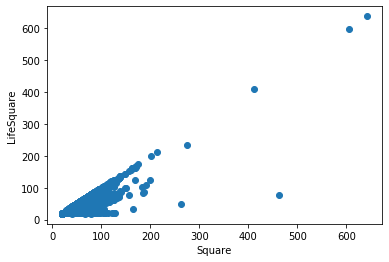

In [21]:
draw_scatter('Square', 'LifeSquare', train_df)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002810B0ECCC8>,
      dtype=object)

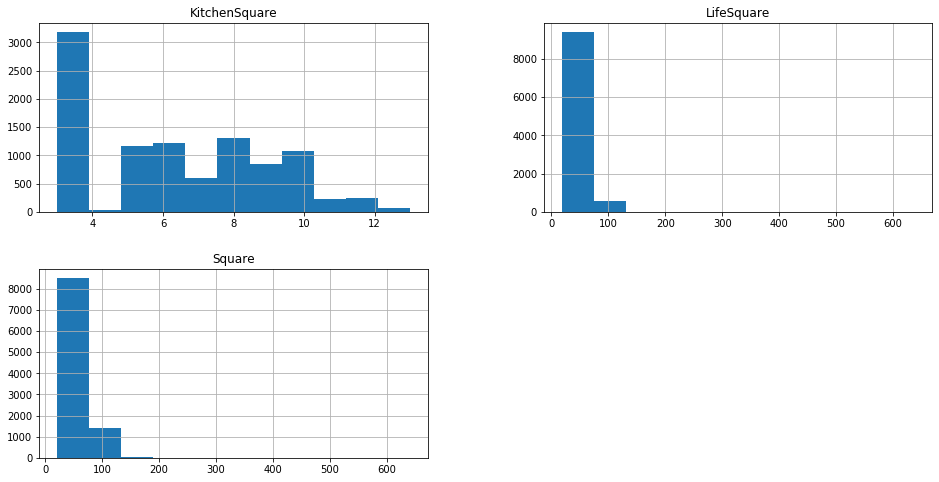

In [22]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].hist(bins=11, figsize = (16, 8))

In [23]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.501230,40.387689,6.238200
std,21.530363,20.763987,2.794717
min,20.908639,18.000000,3.000000
25%,41.866858,25.270030,3.000000
50%,52.633651,35.470634,6.000000
75%,66.004634,48.628695,8.000000
max,641.065193,638.163193,13.000000


#### Обработка столбца Healthcare_1

Признак *Healthcare_1* содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [24]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [25]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.rooms_quantile_5 = None
        self.rooms_quantile_95 = None
        self.housefloor_mode = None
        self.lifesquare_quantile_5 = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет статистик
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.rooms_quantile_5 = X['Rooms'].quantile(.05)
        self.rooms_quantile_95 = X['Rooms'].quantile(.95)
        self.housefloor_mode = X['HouseFloor'].mode()[0]
        self.lifesquare_quantile_5 = X['LifeSquare'].quantile(0.05)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[(X['Rooms'] <= 0), 'Rooms'] = self.rooms_quantile_5
        X.loc[(X['Rooms'] >= 6), 'Rooms'] = self.rooms_quantile_95

        # HouseFloor, Floor
        X.loc[(X['HouseFloor'] <= 0), 'HouseFloor'] = 1
        X.loc[(X['HouseFloor'] > 95), 'HouseFloor'] = self.housefloor_mode
        floor_great_house = X.loc[(X['Floor'] > X['HouseFloor'])].index
        X.loc[floor_great_house, 'Floor'] = X.loc[floor_great_house, 'HouseFloor'].apply(lambda x: random.randint(1,x))
         
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] < 3), 'KitchenSquare'] = 3
                
        # HouseYear
        current_year = datetime.now().year
      
        X.loc[(X['HouseYear'] <= current_year), 'HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'] > current_year), 'HouseYear_outlier'] = 1
        X.loc[(X['HouseYear'] > current_year), 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        # Square
        
        X.loc[(X['Square'] < 18), 'Square'] = 18
        X.loc[(X['Square'] > 830), 'Square'] = self.medians['Square']
        
        # LifeSquare
        X.loc[~(X['LifeSquare'].isna()),'LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(),'LifeSquare_nan'] = 1
        
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X.loc[(X['LifeSquare'] < self.lifesquare_quantile_5 ), 'LifeSquare'] = self.lifesquare_quantile_5
        X.loc[(train_df['LifeSquare'] > 810), 'LifeSquare'] = self.medians['LifeSquare']
        incorrect_lifesquare = X.loc[(X['LifeSquare'] > X['Square']), ['Square', 'LifeSquare']].index
        X.loc[incorrect_lifesquare, ['Square', 'LifeSquare']] = X.loc[incorrect_lifesquare, ['LifeSquare', 'Square']].values
        X.loc[(X['LifeSquare'] > X['Square']), ['LifeSquare', 'Square']]
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Dummies

In [26]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [27]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [28]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,0,0,1,305018.871089,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1,0,1,177734.553407,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,3,1,1,282078.720850,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,1,264,0,0,1,1,168106.007630,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,0,6,1,343995.102962,0,89


In [29]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [30]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [31]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,652,1,243966.403596
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,89,0,201584.441255


#### MedPriceByFloorYear

In [32]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X


In [33]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    0
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [34]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,652,1,243966.403596,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,89,0,201584.441255,3,5


In [35]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,348257.564987
1,1,2,322905.044793
2,1,3,425423.585714
3,1,4,274992.472366
4,2,1,467230.539057


In [36]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,1,851,1,213530.788443,6,2,164803.070010
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,78,0,146032.829834,3,3,193764.932610
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,652,1,243966.403596,4,1,202620.278168
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,1,168106.007630,1,652,1,146735.671740,3,4,183595.406754
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,89,0,201584.441255,3,5,171739.199220


In [37]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        #X.loc[~(X['DistrictSize'].isna()), 'new_district'] = 0
        #X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            

### Отбор признаков

In [38]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [39]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1']

new_feature_names = ['LifeSquare_nan', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 'year_cat', 
                     'floor_cat', 'MedPriceByFloorYear']

target_name = 'Price'

### Разбиение на train и test

In [40]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [42]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 20), (3300, 20), (5000, 20))

In [43]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,HouseYear_outlier,LifeSquare_nan
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,8400.447015,50.159701,1.891493,56.497253,40.175095,6.200746,7.264179,12.602388,1984.821940,0.119933,24.778209,5379.070000,7.888209,1.310597,4.217761,0.000149,0.211343
std,4888.123259,43.501559,0.808792,22.424599,21.936426,2.740751,5.164880,6.533033,18.298101,0.119618,17.629568,4033.819223,23.400692,1.492412,4.766738,0.012217,0.408292
min,0.000000,0.000000,1.000000,18.000000,17.672890,3.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4152.250000,20.000000,1.000000,42.038820,25.226269,3.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,8389.500000,35.000000,2.000000,52.718074,35.604178,6.000000,6.000000,13.000000,1977.000000,0.075779,25.000000,5285.000000,2.000000,1.000000,3.000000,0.000000,0.000000
75%,12665.500000,75.000000,2.000000,65.841734,48.441045,8.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,0.000000,0.000000
max,16797.000000,209.000000,5.000000,641.065193,638.163193,12.000000,42.000000,48.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,1.000000


In [44]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [45]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [46]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,...,Social_3,Helthcare_2,Shops_1,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.891493,56.497253,40.175095,6.200746,7.264179,12.602388,1984.821940,0.119933,0.971642,24.778209,...,7.888209,1.310597,4.217761,0.211343,164.111045,0.387761,212291.614001,2.806269,1.628955,197606.095477
std,0.808792,22.424599,21.936426,2.740751,5.164880,6.533033,18.298101,0.119618,0.166006,17.629568,...,23.400692,1.492412,4.766738,0.408292,183.507109,0.487276,78211.226488,1.159766,1.304143,28914.518053
min,1.000000,18.000000,17.672890,3.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69623.753191,0.000000,0.000000,165526.307915
25%,1.000000,42.038820,25.226269,3.000000,3.000000,9.000000,1974.000000,0.017647,1.000000,6.000000,...,0.000000,0.000000,1.000000,0.000000,37.000000,0.000000,164116.183543,2.000000,0.000000,179400.122541
50%,2.000000,52.718074,35.604178,6.000000,6.000000,13.000000,1977.000000,0.075779,1.000000,25.000000,...,2.000000,1.000000,3.000000,0.000000,65.000000,0.000000,195474.299127,2.000000,2.000000,189590.749712
75%,2.000000,65.841734,48.441045,8.000000,10.000000,17.000000,2001.000000,0.195781,1.000000,36.000000,...,5.000000,2.000000,6.000000,0.000000,345.000000,1.000000,241279.064990,4.000000,3.000000,206782.391302
max,5.000000,641.065193,638.163193,12.000000,42.000000,48.000000,2021.000000,0.521867,1.000000,74.000000,...,141.000000,6.000000,23.000000,1.000000,580.000000,1.000000,624156.003381,5.000000,4.000000,624156.003381


### Построение модели

In [47]:
# Для модели RandomForestRegressor оптимальные параметры n_estimators=170, max_depth=14, max_features=2
rf_model = RandomForestRegressor(n_estimators=170, max_depth=14, max_features=2, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=170,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.927
Test R2:	0.735


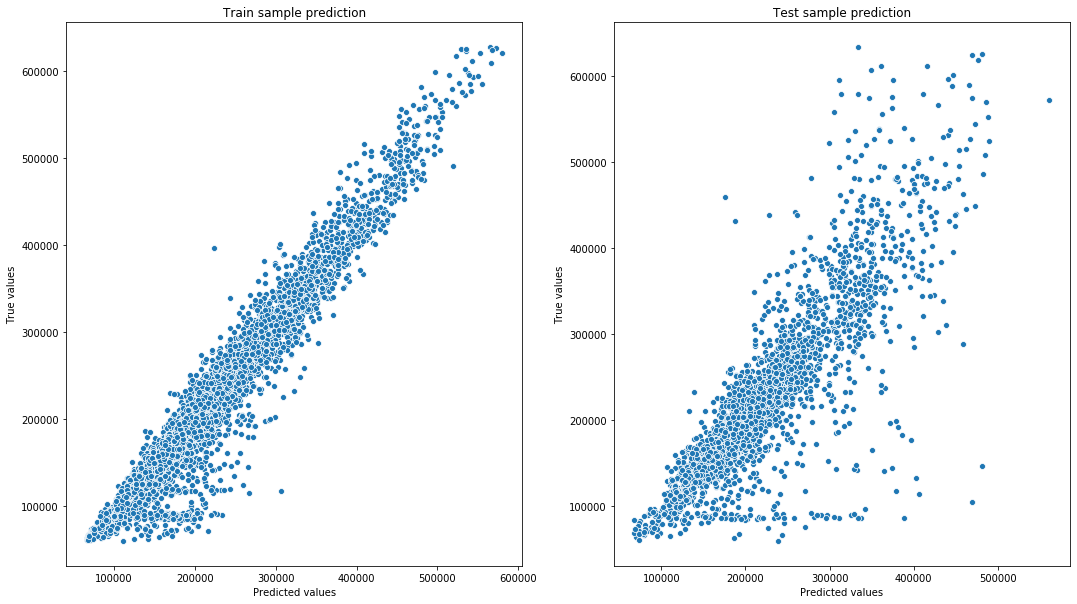

In [48]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.864
Test R2:	0.72


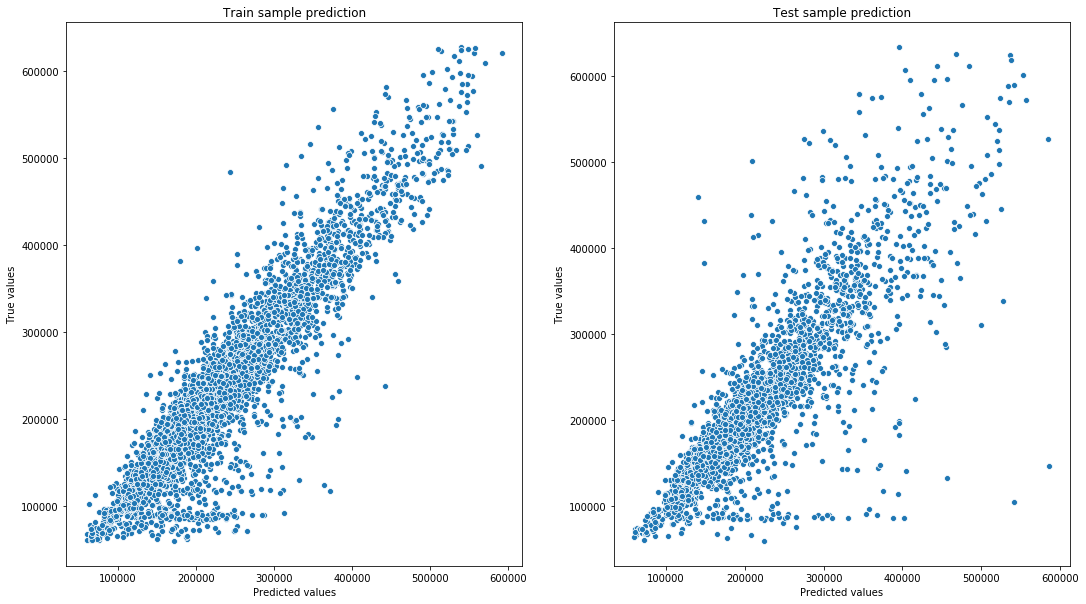

In [49]:
# Для модели GradientBoostingRegressor оптимальные параметры n_estimators=300, max_depth=5, min_samples_leaf=75
gb_model = GradientBoostingRegressor(max_depth=5, min_samples_leaf=75, random_state=42, n_estimators=300)
gb_model.fit(X_train, y_train)
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.935
Test R2:	0.738


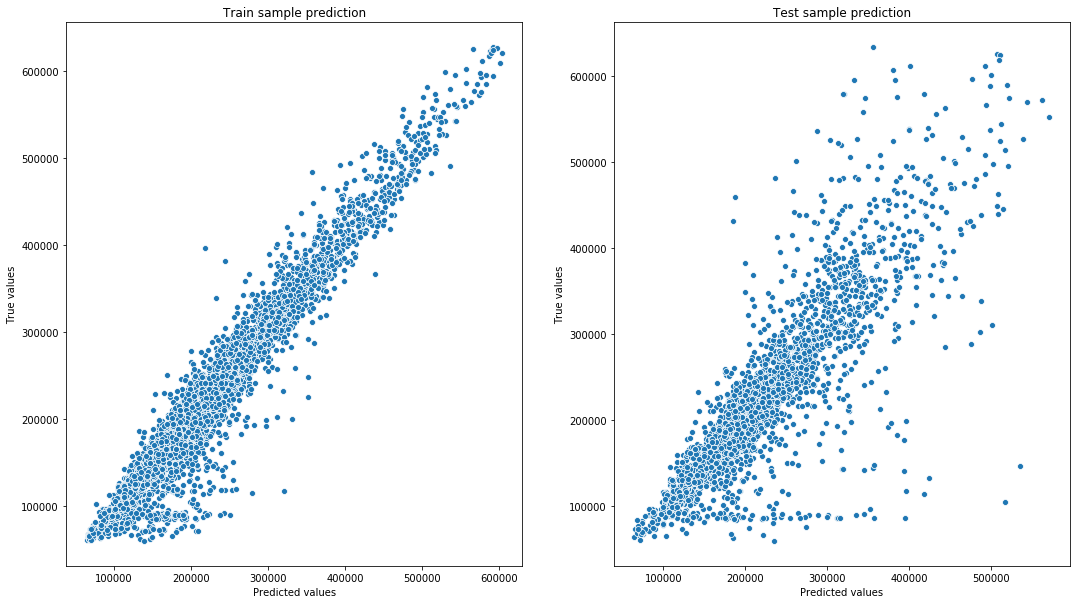

In [58]:
# Усредним прогноз двух предыдущих моделей с помощью VotingRegressor

r = RandomForestRegressor(random_state=42,
                                 criterion='mse',
                                 n_estimators=170,
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 max_depth=14,
                                 bootstrap=False)

gb = GradientBoostingRegressor(random_state=42,
                                    n_estimators=300,
                                    min_samples_split=12,
                                    min_samples_leaf=5,
                                    max_features='sqrt',
                                    max_depth=5,
                                    criterion='mse')

er_model = VotingRegressor([('r', r), ('gb', gb)])
er_model.fit(X_train, y_train)

y_train_preds = er_model.predict(X_train)
y_test_preds = er_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [60]:
cv_score = cross_val_score(er_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.80276403, 0.73944063, 0.75274754, 0.76894055, 0.78338519])

In [62]:
cv_score.mean()

0.7694555870348911

### Важность признаков

In [64]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,MedPriceByDistrict,0.728493
1,Square,0.110498
15,DistrictSize,0.019253
11,Social_3,0.018684
6,HouseYear,0.015687
20,MedPriceByFloorYear,0.015578
2,LifeSquare,0.015121
10,Social_2,0.013402
7,Ecology_1,0.011679
9,Social_1,0.011090


### Прогнозирование на тестовом датасете

In [65]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [66]:
predictions = er_model.predict(test_df)
predictions

array([161959.03653146, 128889.74231143, 142957.20488811, ...,
       148671.33432811, 190087.35208935, 230939.59832623])

In [67]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161959.036531
1,5925,128889.742311
2,960,142957.204888
3,3848,125902.768645
4,746,175516.695698


In [68]:
submit.to_csv('kav_submit.csv', index=False)